```python
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# -----------------------------
# 설정
# -----------------------------
img_height = 32       # 셀 이미지 높이
img_width = 128       # 셀 이미지 폭
num_channels = 1      # 흑백 이미지
max_text_length = 10  # 한 셀 최대 글자 길이
characters = "0123456789DST"  # 인식할 문자 집합
num_classes = len(characters) + 1  # CTC용 blank 문자 추가

# 문자 → 인덱스
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="", invert=True)

# -----------------------------
# CNN + BiLSTM + CTC 모델
# -----------------------------
def build_model():
    input_img = layers.Input(shape=(img_height, img_width, num_channels), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # CNN 출력 → 시퀀스 변환
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = models.Model(inputs=input_img, outputs=output)
    return model

# -----------------------------
# CTC Loss 계산용 레이어
# -----------------------------
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# -----------------------------
# 모델 컴파일
# -----------------------------
base_model = build_model()
labels = layers.Input(name='label', shape=(max_text_length,), dtype='float32')

output = CTCLossLayer()(labels, base_model.output)
model = models.Model(inputs=[base_model.input, labels], outputs=output)

model.compile(optimizer='adam')
model.summary()

# -----------------------------
# 데이터 준비 예시
# -----------------------------
# X: (num_samples, img_height, img_width, 1)
# y: (num_samples, max_text_length) 정수 인덱스
# 실제 학습 시에는 셀 이미지를 crop해서 resize 후 char_to_num으로 변환

# X_dummy = np.random.rand(32, img_height, img_width, 1).astype(np.float32)
# y_dummy = np.random.randint(0, num_classes, size=(32, max_text_length))

# model.fit([X_dummy, y_dummy], y_dummy, epochs=10, batch_size=8)

In [1]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# -------------------------
# 1. 설정 정의
# -------------------------

# CSV key 목록
RE_KEYS = ('DE', 'DR', 'V')

# 기본 숫자 변환기
parse_int = lambda x: int(x) if x else 0
parse_int_comma = lambda x: int(x.replace(',', '')) if x else 0

# CSV 컬럼별 변환 함수
CONVERTERS = {
    'T': lambda x: int(x) if x else 1,
    'R': lambda x: x if x else 'A',
    'E': parse_int,
    'A': parse_int,
    'DE': parse_int,
    'DA': parse_int_comma,
    'H': parse_int_comma,
    'M': parse_int_comma,
}

# 컬럼별 dtype
DTYPES = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16'
}


# -------------------------
# 2. CSV 데이터 읽기 & 병합
# -------------------------

def load_re_data():
    df_list = []
    for key in RE_KEYS:
        df = read_csv(f'R/{key}.csv', index_col=0, converters=CONVERTERS)
        df = df.astype(DTYPES, copy=False)
        df_list.append(df)
    return pd.concat(df_list, keys=RE_KEYS, names=('RE',))


df = load_re_data()
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [3]:
# -------------------------
# 3. 첫 2개 컬럼은 범주형 → 코드화
#    나머지 숫자 컬럼은 자리수별로 분해
# -------------------------

category_cols = df.columns[:2].to_list()
numeric_cols = df.columns[2:].to_list()
category_cols, numeric_cols

(['T', 'R'], ['E', 'A', 'DE', 'DA', 'H', 'M'])

In [4]:
from pandas import DataFrame
from math import floor, log10


def split_digits(series: pd.Series) -> DataFrame:
    """정수 Series를 각 자리수로 나누어 DataFrame 반환"""
    max_value = series.max()
    max_digit = floor(log10(max_value)) if max_value > 0 else 0

    result = {}
    for pos in range(max_digit, -1, -1):
        result[f'{series.name}{pos}'] = (series // 10 ** pos % 10).astype('uint8', copy=False)
    return DataFrame(result)


# 최종 변환 테이블
encoded = DataFrame({col: df[col].cat.codes.astype('uint8', copy=False) for col in category_cols})

for col in numeric_cols:
    encoded = pd.concat([encoded, split_digits(df[col])], axis=1)

encoded

T  R  E1  E0  A1  A0  DE1  DE0  DA4  DA3  ...  H4  H3  H2  H1  H0  M4  \
RE I                                              ...                           
DE 1    0  1   0   0   0   0    0    8    0    2  ...   0   1   4   2   5   0   
   1    0  2   0   1   0   0    0    3    0    1  ...   0   0   0   0   0   0   
   1    0  2   0   2   0   0    0    7    0    4  ...   0   0   4   8   7   0   
   1    0  3   0   1   0   0    0    3    0    2  ...   0   2   7   4   8   0   
   1    0  3   0   1   0   1    0    3    0    0  ...   0   5   8   4   8   0   
...    .. ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ..  ..  ..  ..  ..  ..   
V  467  1  1   0   7   0   2    0    4    0    6  ...   0   0   0   0   0   0   
   467  1  2   1   0   0   0    0    5    0    6  ...   0   0   0   6   2   0   
   467  1  2   0   6   0   1    0    7    0    5  ...   0   0   0   7   8   0   
   467  1  3   0   5   0   1    0    6    0    4  ...   0   8   2   1   1   0   
   467  1  3   0   2   0   5    0    7    0    1  ...   0   7   3   9   6   0   

        M3  M2  M1  M0  
RE I                    
DE 1     4   6   1   1  
   1     0   6   5   0  
   1     0   3   0   8  
   1     0   0   0   0  
   1     0   1   8   9  
...     ..  ..  ..  ..  
V  467   9   6   6   5  
   467   1   4   1   7  
   467   0   0   7   6  
   467   0   7   1   6  
   467   0   3   2   9  

[9110 rows x 23 columns]

In [5]:
encoded.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   T       9110 non-null   uint8
 1   R       9110 non-null   uint8
 2   E1      9110 non-null   uint8
 3   E0      9110 non-null   uint8
 4   A1      9110 non-null   uint8
 5   A0      9110 non-null   uint8
 6   DE1     9110 non-null   uint8
 7   DE0     9110 non-null   uint8
 8   DA4     9110 non-null   uint8
 9   DA3     9110 non-null   uint8
 10  DA2     9110 non-null   uint8
 11  DA1     9110 non-null   uint8
 12  DA0     9110 non-null   uint8
 13  H4      9110 non-null   uint8
 14  H3      9110 non-null   uint8
 15  H2      9110 non-null   uint8
 16  H1      9110 non-null   uint8
 17  H0      9110 non-null   uint8
 18  M4      9110 non-null   uint8
 19  M3      9110 non-null   uint8
 20  M2      9110 non-null   uint8
 21  M1      9110 non-null   uint8
 22  M0      9110 n

In [6]:
# 전체 열을 10단위 길이 벡터로 변환
reshaped = tuple(encoded.to_numpy().reshape(-1, encoded.shape[1] * 10).T)
len(reshaped)

230

2025-11-20 07:04:55.628102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763622295.648127    1200 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763622295.655447    1200 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763622295.673191    1200 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763622295.673215    1200 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763622295.673217    1200 computation_placer.cc:177] computation placer alr

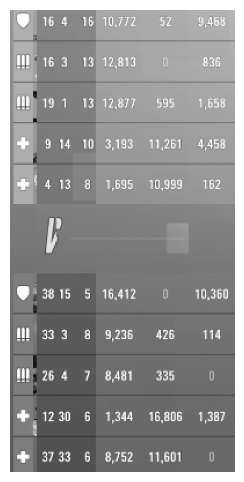

0 1 1 6 0 4 1 6 1 0 7 7 2 0 0 0 5 2 0 9 4 6 8 0 2 1 6 0 3 1 3 1 2 8 1 3 0 0 0 0 0 0 0 8 3 6 0 2 1 9 0 1 1 3 1 2 8 7 7 0 0 5 9 5 0 1 6 5 8 0 3 0 9 1 4 1 0 0 3 1 9 3 1 1 2 6 1 0 4 4 5 8 0 3 0 4 1 3 0 8 0 1 6 9 5 1 0 9 9 9 0 0 1 6 2 1 1 3 8 1 5 0 5 1 6 4 1 2 0 0 0 0 0 1 0 3 6 0 1 2 3 3 0 3 0 8 0 9 2 3 6 0 0 4 2 6 0 0 1 1 4 1 2 2 6 0 4 0 7 0 8 4 8 1 0 0 3 3 5 0 0 0 0 0 1 3 1 2 3 0 0 6 0 1 3 4 4 1 6 8 0 6 0 1 3 8 7 1 3 3 7 3 3 0 6 0 8 7 5 2 1 1 6 0 1 0 0 0 0 0


2025-11-20 07:05:03.561739: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show


# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (400, 194)) / 255
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(reshaped)

dataset = (
    Dataset.from_tensor_slices((image_paths, reshaped))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [13]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=x_batch.shape[1:])

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(.4)(x)

# ==========================
# 다중 출력층 생성
# ==========================

nunique_dict = encoded.nunique().to_dict()
outputs = []
for i in range(10):
    for key in nunique_dict:
        if nunique_dict[key] <= 2:
            outputs.append(Dense(1, name=f'{key}_{i}')(x))
        else:
            outputs.append(Dense(nunique_dict[key], name=f'{key}_{i}')(x))
model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

loss = {}
for i in range(10):
    for key in nunique_dict:
        if nunique_dict[key] <= 2:
            loss[f'{key}_{i}'] = BinaryCrossentropy(True)
        else:
            loss[f'{key}_{i}'] = SparseCategoricalCrossentropy(True)
metrics = {}
for i in range(10):
    for key in nunique_dict:
        metrics[f'{key}_{i}'] = 'accuracy'
model.compile('adamw', loss, metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 194,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 194,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 400, 194,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 97,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 97,   │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 97,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 97,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 48,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 48,   │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 48,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 48,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 24,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 153600)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 39,321,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ re_lu_3[0][0]   

 Total params: 39,881,138 (152.13 MB)

 Trainable params: 39,880,178 (152.13 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
from tensorflow.keras.callbacks import Callback, EarlyStopping


class MetricSummaryCallback(Callback):
    def __init__(self, metric_groups=encoded.columns):
        super().__init__()
        self.metric_groups = metric_groups

    def on_train_begin(self, logs=None):
        self.total_epochs = self.params.get('epochs', None)

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1
        total_epochs = self.total_epochs or '?'
        print(f'{epoch_num}/{total_epochs}')

        for group in self.metric_groups:
            # 관련 로그 필터링
            related_logs = {
                key: value for key, value in logs.items()
                if key.startswith(f'val_{group}')
            }

            # accuracy 계산
            acc_values = [
                v for k, v in related_logs.items() if k.endswith('_accuracy')
            ]
            avg_acc = sum(acc_values) / len(acc_values) if acc_values else None

            # loss 계산
            loss_values = [
                v for k, v in related_logs.items() if k.endswith('_loss')
            ]
            avg_loss = sum(loss_values) / len(loss_values) if loss_values else None

            print(
                f'- {group} '
                f'- val_accuracy: {avg_acc:.4f} '
                f'- val_loss: {avg_loss:.4f}'
            )


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(patience=16, verbose=1, restore_best_weights=True)

# 학습
history = model.fit(
    train_ds,
    epochs=256,
    verbose=0,
    callbacks=(MetricSummaryCallback(), early_stop),
    validation_data=val_ds
)

1/256
- T - val_accuracy: 0.6057 - val_loss: 0.5932
- R - val_accuracy: 0.7372 - val_loss: 1.1406
- E1 - val_accuracy: 0.2526 - val_loss: 1.7269
- E0 - val_accuracy: 0.1010 - val_loss: 2.3271
- A1 - val_accuracy: 0.5639 - val_loss: 1.6657
- A0 - val_accuracy: 0.1172 - val_loss: 2.3052
- DE1 - val_accuracy: 0.4662 - val_loss: 1.0063
- DE0 - val_accuracy: 0.1125 - val_loss: 2.3172
- DA4 - val_accuracy: 0.5134 - val_loss: 1.0109
- DA3 - val_accuracy: 0.1080 - val_loss: 2.2974
- DA2 - val_accuracy: 0.1047 - val_loss: 2.3414
- DA1 - val_accuracy: 0.1027 - val_loss: 2.3321
- DA0 - val_accuracy: 0.1017 - val_loss: 2.3383
- H4 - val_accuracy: 0.7659 - val_loss: 0.9417
- H3 - val_accuracy: 0.1398 - val_loss: 2.2136
- H2 - val_accuracy: 0.1784 - val_loss: 2.2701
- H1 - val_accuracy: 0.2741 - val_loss: 2.2277
- H0 - val_accuracy: 0.0912 - val_loss: 2.2824
- M4 - val_accuracy: 0.7827 - val_loss: 1.0314
- M3 - val_accuracy: 0.4126 - val_loss: 2.0818
- M2 - val_accuracy: 0.1925 - val_loss: 2.2443
- 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


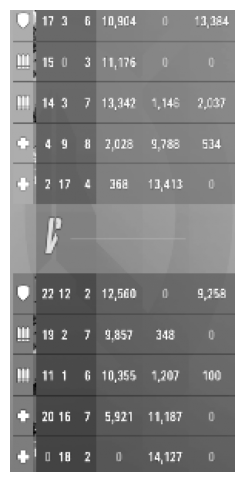

0.0 1.0 0.2982456 0.048387095 0.26086956 0.36441416 0.0 0.39019272 0.0 2.0 0.2631579 0.0 0.13043478 0.37350443 0.0 0.0 0.0 2.0 0.24561404 0.048387095 0.3043478 0.44589266 0.043377873 0.059386022 0.0 3.0 0.07017544 0.14516129 0.3478261 0.06777622 0.37049094 0.015568059 0.0 3.0 0.03508772 0.27419356 0.17391305 0.012298644 0.50770277 0.0 1.0 1.0 0.3859649 0.19354838 0.08695652 0.41975805 0.0 0.26990467 1.0 2.0 0.33333334 0.032258064 0.3043478 0.32942316 0.013172338 0.0 1.0 2.0 0.19298245 0.016129032 0.26086956 0.34606645 0.045686815 0.0029153668 1.0 3.0 0.3508772 0.2580645 0.3043478 0.19788116 0.42344525 0.0 1.0 3.0 0.0 0.29032257 0.08695652 0.0 0.53472877 0.0


2025-11-16 06:31:24.817139: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from numpy import array

for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = tuple(y[0] for y in y_batch)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [15]:
import numpy as np

In [16]:
y_sample_ = (array(y_sample).reshape(-1, 8) * ([1, 1] + numeric_max.tolist())).round().astype('uint16')
y_sample_

array([[    0,     1,    17,     3,     6, 10904,     0, 13384],
       [    0,     2,    15,     0,     3, 11176,     0,     0],
       [    0,     2,    14,     3,     7, 13342,  1146,  2037],
       [    0,     3,     4,     9,     8,  2028,  9788,   534],
       [    0,     3,     2,    17,     4,   368, 13413,     0],
       [    1,     1,    22,    12,     2, 12560,     0,  9258],
       [    1,     2,    19,     2,     7,  9857,   348,     0],
       [    1,     2,    11,     1,     6, 10355,  1207,   100],
       [    1,     3,    20,    16,     7,  5921, 11187,     0],
       [    1,     3,     0,    18,     2,     0, 14127,     0]],
      dtype=uint16)

In [17]:
print(f'T R  E  A DE  DA    H    M')
for i in range(10):
    print(f'{int(y_pred[0 + i * 8][0][0] >= 0.5):1d}', end=' ')
    print(f'{y_pred[1 + i * 8][0].argmax():1d}', end=' ')
    print(f'{int((y_pred[2 + i * 8][0][0] * numeric_max[0]).round()):2d}', end=' ')
    print(f'{int((y_pred[3 + i * 8][0][0] * numeric_max[1]).round()):2d}', end=' ')
    print(f'{int((y_pred[4 + i * 8][0][0] * numeric_max[2]).round()):1d}', end=' ')
    print(f'{int((y_pred[5 + i * 8][0][0] * numeric_max[3]).round()):4d}', end=' ')
    print(f'{int((y_pred[6 + i * 8][0][0] * numeric_max[4]).round()):4d}', end=' ')
    print(f'{int((y_pred[7 + i * 8][0][0] * numeric_max[5]).round()):4d}', end=' ')
    print()

T R  E  A DE  DA    H    M
0 1  2  1 1 1034  151 1213 
0 2  1  2 0 1280 -127 -715 
0 2  2  1 1  116    3 -121 
0 3  1  1 1  329  498  121 
0 3  0  1 1  189  864 -471 
1 1  3  1 1 1161  -20  488 
1 2  1  1 0 1063  325   -4 
1 2  1 -1 1 1419  630 -297 
1 3  1  2 1  158  777 -338 
1 3  2  3 1  180 1135 1589 


자릿수 나눠서 학습해 보자! 가능성이 있다!